In [ ]:
'''
Using features generated using HOG, show the model perfomance:
    accuracy
    precision
    recall
    f1-score
for the models:
    Random Forest
    Support Vector Classifier
    Linear SVC
    Logistic Regression
    K-Nearest Neighbor
    Artificial Neural Network
    Decision Tree
for the base model as well as with tuned hyper-parameters
Cross-validation is used
'''

In [1]:
#for array manipulations
import numpy as np
#for image processing
import cv2 
#for displaying images
import matplotlib.pyplot as plt
#to display images in this notebook, not in a separate window
%matplotlib inline
#to access system resources such as directories
import os
import time
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
#Set this to point to the project root; all paths will be relative to this one
project_dir = 'C:/Users/VINCENT/Dropbox/PC/Documents/maize-disease-detection'

In [4]:
def set_up_directories(project_dir=project_dir):
    """Sets up the paths to important directories
    
    Parameters
    ----------
    project_dir : string; default is the current working directory
        The path to the project root i.e '/home/vincent/projects/maize-disease-detection'
    
    returns
    -------
    base_dir : string
        The project directory path
    data_folder : string
        The data subfolder path
    maize_data_folder : 
        The path to the subdirectory containing the maize images
        
    example usage
    -------------
    base_dir, data_folder, maize_data_folder = set_up_directories()
    """
    
    #set our base directory. This should point to the location of the plant-diseases folder
    base_dir = project_dir
    #set the path to our data folder
    data_folder = os.path.join(base_dir, 'data')
    #set the path to the maize folder and list the various categories available
    maize_data_folder = os.path.join(data_folder, 'maize')

    return base_dir, data_folder, maize_data_folder

def get_images(disease, image_count=200, offset=0):
    """Loads a specified number of images for a given maize disease
    
    parameters
    ----------
    disease: string
        A string that could be common_rust, healthy, leaf_spot, nothern_leaf_blight
    image_count : int
        Number of images to return
    returns
    -------
    disease_images: list
        A list of images for the selected disease
    offset : int
        Where to begin
    """
    
    #this list will contain the  images returned
    disease_images = []
    #path to the images
    disease_images_path = os.path.join(maize_data_folder, disease)
    count = 0
    image_paths = os.listdir(disease_images_path)
    for image_path in image_paths[offset:]:
        if count == image_count:
            break
        image_path = os.path.join(disease_images_path, image_path)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        disease_images.append(image)
        count += 1
    return disease_images

def extract_features_hog(image, feature_size=4096):
    """Extracts hog features for the image
    
    parameters
    ----------
    image : numpy array
        The image whose features are to be extracted
    feature_size : int
        The number of features to generate
    returns
    -------
        hog_features : numpy array 
        
    raises
    ------
    cv2.error
    """
    hog = cv2.HOGDescriptor()
    try:
        features = hog.compute(image)
        required_features = features[:feature_size].ravel()
    except AttributeError as e:
        raise AttributeError('Unable to generate features for the given image')
    else:    
        return required_features

def extract_train_features(algorithm='hog', dataset_size=200):
    """Extracts features for the given number of images in the dataset

    Uses the specified algorithm
    Generates specified training samples for each maize disease
    parameters
    ----------
    algorithm : string
    ---------
        The algorithm to use; could be 'kaze', 'orb' or 'hog'
    dataset_size : int, optional
        Number of images to load for each category
    returns
    -------
    features : numpy array
        The features used to train the models
    labels : numpy array
        The feature labels
    """

    features = []
    labels = []
    disease_names = ['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']
    for disease_name in disease_names:
        images = get_images(disease_name, image_count=dataset_size)
        for image in images:
            try:
                if algorithm == 'kaze':
                    image_features = extract_features_kaze(image)
                    features.append(image_features)
                elif algorithm == 'orb':
                    image_features = extract_features_orb(image)
                    features.append(image_features)
                else:
                    image_features = extract_features_hog(image)
                    features.append(image_features)
                labels.append(disease_name)
            except AttributeError as e:
                continue
    features = np.array(features)
    labels = np.array(labels)
    features = StandardScaler().fit_transform(features)
    labels = LabelEncoder().fit_transform(labels)
    
    return  features, labels

def extract_test_features(algorithm='hog', dataset_size=400):
    """Extracts features for the given number of images in the dataset

    Uses kaze algorithm
    parameters
    ----------
    algorithm : string
        The algorithm to use; could be 'kaze', 'orb' or 'hog'
    dataset_size : int
        Number of images to load for each category
    returns
    -------
    features : numpy array
        The features used to train the models
    labels : numpy array
        The feature labels
    """

    test_features = []
    test_labels = []
    disease_names = ['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']
    for disease_name in disease_names:
        images = get_images(disease_name, image_count=dataset_size, offset=1050)
        for image in images:
            try:
                if algorithm == 'kaze':
                    image_features = extract_features_kaze(image)
                    test_features.append(image_features)
                elif algorithm == 'orb':
                    image_features = extract_features_orb(image)
                    test_features.append(image_features)
                else:
                    image_features = extract_features_hog(image)
                    test_features.append(image_features)
                test_labels.append(disease_name)
            except AttributeError as e:
                continue
    test_features = np.array(test_features)
    test_labels = np.array(test_labels)
    test_features = StandardScaler().fit_transform(test_features)
    test_labels = LabelEncoder().fit_transform(test_labels)
    
    return  test_features, test_labels

In [5]:
#Directories set up
base_dir, data_folder, maize_data_folder = set_up_directories()

In [6]:
hog_train_features, hog_train_labels = extract_train_features(dataset_size=1200)
hog_train_features.shape, hog_train_labels.shape

((4800, 4096), (4800,))

In [7]:
hog_test_features, hog_test_labels = extract_test_features(dataset_size=400)
hog_test_features.shape, hog_test_labels.shape

((1600, 4096), (1600,))

In [8]:
def create_confusion_matrix(predictions, labels):
    """generates the confusion matrix

    parameters
    ----------
    returns
    -------
    confusion_matrix : numpy array
        The confusion matrix
    """
    cm = confusion_matrix(predictions, labels)

    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, cbar=False)
    plt.title('Confusion Matrix Visualization')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    plt.show()

def create_confusion_matrix_labelled(predictions, labels, diseases=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']):
    """generates the confusion matrix

    parameters
    ----------
    returns
    -------
    confusion_matrix : numpy array
        The confusion matrix
    """
    cm = confusion_matrix(predictions, labels)

    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, cbar=True)
    tick_marks = np.arange(len(diseases))
    plt.xticks(tick_marks, diseases, rotation=45)
    plt.yticks(tick_marks, diseases, rotation=45)
    plt.title('Confusion Matrix Visualization')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def train_model(model, train_features, train_labels):
    """Trains the given model

    Uses cross-validation
    parameters
    ----------
    model
    train_features
    """

    start_time = time.time()
    train_scores = scores = cross_val_score(model, train_features, train_labels, scoring='accuracy', cv=10)
    stop_time = time.time()
    train_time = round((stop_time - start_time), 3)
    train_score = round(np.mean(train_scores), 3)
    return train_score, train_time

def test_model(model, test_features, test_labels):
    """Trains the given model

    Uses cross-validation
    parameters
    ----------
    model
    train_features
    """

    test_predictions = cross_val_predict(model, test_features, test_labels, cv=10)
    test_score = round(accuracy_score(test_labels, test_predictions), 3)
    prescision = round(precision_score(test_labels, test_predictions, average='micro'), 3)
    recall = round(recall_score(test_labels, test_predictions, average='micro'), 3)
    f_1 = round(f1_score(test_labels, test_predictions, average='micro'), 3)
    return test_score

def model_classification_report(model, test_features, test_labels, diseases=['common_rust', 'healthy', 'leaf_spot', 
                                                                             'nothern_leaf_blight']):
    predictions = model.predict(test_features)
    encoder = LabelEncoder()
    encoded_labels= encoder.fit_transform(diseases)
    decoded_predictions = encoder.inverse_transform(predictions)
    decoded_test_labels = encoder.inverse_transform(test_labels)
    print(classification_report(decoded_test_labels, decoded_predictions,  
                        labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']))

def model_perfomance(model, name, train_set=(hog_train_features, hog_train_labels), 
                     test_set=(hog_test_features, hog_test_labels)):
    """Model perfomance on the hog dataset

    parameters
    ----------
    model : scikit-learn Classifier
        Model to be tested
    returns
    -------
    model_perfomance : pandas DataFrame
    """

    #Assert dataset shape and type

    import warnings
    warnings.filterwarnings('ignore')

    #Training accuracy and Time
    print(f'**********{name}**********')
    print('\n')
    train_score, train_time = train_model(model, train_set[0], train_set[1])

    #Test Accuracy
    model.fit( train_set[0], train_set[1])
    test_score = test_model(model, test_set[0], test_set[1]) 

    #The model perfomance 
    df = pd.DataFrame({'Model': [name], 'Train Accuracy': [train_score], 'Test Accuracy': [test_score], 'Train Time':[train_time]})
    print(df)
    print('\n')

    #The classification report
    model_classification_report(model, test_set[0], test_set[1])
    print('\n')

    #The confusion matrix
    predictions = model.predict(test_set[0])
    #create_confusion_matrix(predictions, test_set[1])
    create_confusion_matrix_labelled(predictions, test_set[1])
    print('\n')
    print('*********The Key**********')
    print('\t0: Common Rust\n\t1: Healthy\n\t2: Leaf Spot\n\t3: Nothern Leaf Blight')

In [9]:
neural_network_tuned = MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=1e-05, validation_fraction=0.1, verbose=False,
              warm_start=False)

**********Neural Network Tuned**********


                  Model  Train Accuracy  Test Accuracy  Train Time
0  Neural Network Tuned           0.801          0.779    1233.347


                     precision    recall  f1-score   support

        common_rust       0.98      0.97      0.98       400
            healthy       0.86      0.89      0.87       400
          leaf_spot       0.91      0.86      0.89       400
nothern_leaf_blight       0.81      0.84      0.83       400

           accuracy                           0.89      1600
          macro avg       0.89      0.89      0.89      1600
       weighted avg       0.89      0.89      0.89      1600





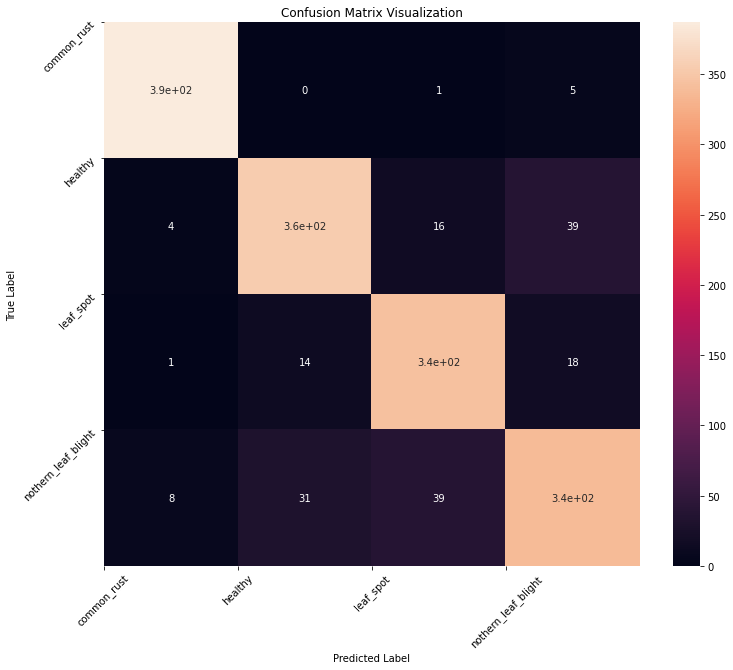



*********The Key**********
	0: Common Rust
	1: Healthy
	2: Leaf Spot
	3: Nothern Leaf Blight


In [10]:
model_perfomance(neural_network_tuned, 'Neural Network Tuned')

In [59]:
      
random_forest_tuned = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=2000,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

********** Random Forest Tuned**********


                  Model  Train Accuracy  Test Accuracy  Train Time
0   Random Forest Tuned           0.804          0.802   18511.419


                     precision    recall  f1-score   support

        common_rust       0.98      0.94      0.96       400
            healthy       0.86      0.92      0.89       400
          leaf_spot       0.98      0.88      0.92       400
nothern_leaf_blight       0.82      0.89      0.85       400

           accuracy                           0.91      1600
          macro avg       0.91      0.91      0.91      1600
       weighted avg       0.91      0.91      0.91      1600





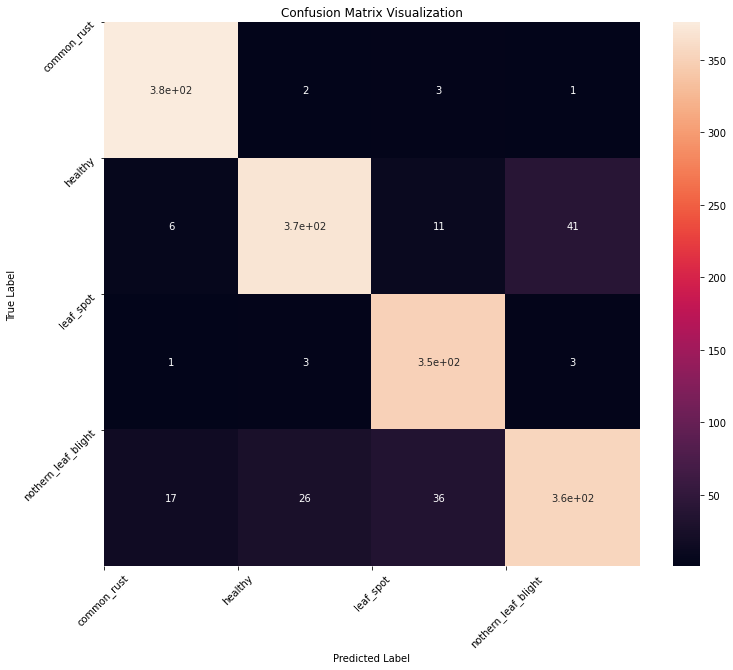



*********The Key**********
	0: Common Rust
	1: Healthy
	2: Leaf Spot
	3: Nothern Leaf Blight


In [60]:
#BE WARNED THIS TOOK 1208.377s
model_perfomance(random_forest_tuned,' Random Forest Tuned')

In [61]:
models = [
          (linear_svc_tuned),
          (logistic_regression_tuned),
          (k_nearest_tuned),
          (svc_tuned),
          (decision_tree_tuned),
          (neural_network_tuned),
          (random_forest_tuned)
]
names = [
         'Linear SVC',
         'Logistic Regression',
         'K-Nearest Neighbor',
         'Support Vector Classifier',
         'Decision Tree',
         'Artificial Neural Network',
         'Random Forest'
]

In [62]:
def results(models=models, names=names, train_set=(hog_train_features, hog_train_labels), 
                     test_set=(hog_test_features, hog_test_labels)):
    #Assert that train_set and test_set are both tuples, shape
    #Assert that shapes of train set and test set are appropriate
    #assert shape of models and names
    #assert contents of models and names
    model_train_accuracy_tuned = []
    model_test_accuracy_tuned = []
    model_train_time_tuned = []
    for model_tuned in models:

        train_accuracy_tuned, train_time_tuned = train_model(model_tuned, train_set[0], train_set[1])
        model_train_accuracy_tuned.append(train_accuracy_tuned)
        model_train_time_tuned.append(train_time_tuned)

        model_tuned.fit( train_set[0], train_set[1])
        test_score_tuned = test_model(model_tuned, test_set[0], test_set[1])
        model_test_accuracy_tuned.append(test_score_tuned)
                                      
    df = pd.DataFrame({'Model': names,'Tuned Train Accuracy': model_train_accuracy_tuned, 
                       'Tuned Test Accuracy': model_test_accuracy_tuned, 'Tuned Train Time': model_train_time_tuned})
    df = df.sort_values(by=['Tuned Train Accuracy'], ascending=False)
    return df

In [ ]:
#Took around 1700s
results()